In [1]:
import numpy as np
import tensorflow as tf
import collections, random, math, os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/home/cyclops/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Import data

In [3]:
from sklearn.datasets import fetch_20newsgroups
# from sklearn.feature_extraction.text import CountVectorizer

In [4]:
news_train = fetch_20newsgroups(
    data_home='../data/20newsgroups/', 
    subset='train', remove=('headers', 'footers', 'quotes'))
# news_test = fetch_20newsgroups(
#     data_home='../data/20newsgroups/', 
#     subset='test')

In [5]:
data = news_train.data
new_data = []
for d_string in data:
    new_data += d_string.replace('\n', ' ').replace('.', ' ').lower().strip().split()

In [6]:
vocabulary_size = 100000

In [7]:
def build_dataset(words, n_words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
              unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(
    new_data, vocabulary_size)
del new_data

In [8]:
data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
        batch[i * num_skips + j] = buffer[skip_window]
        labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
        buffer.extend(data[0:span])
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels


batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)

22 was -> 1275 wondering
22 was -> 8 i
1275 wondering -> 23 if
1275 wondering -> 22 was
23 if -> 132 anyone
23 if -> 1275 wondering
132 anyone -> 56 out
132 anyone -> 23 if


In [9]:
batch_size = 128
embedding_size = 300
skip_window = 1
num_skips = 2 
num_sampled = 64  

valid_size = 16  
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [18]:
graph = tf.Graph()

with graph.as_default():

    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    embeddings = tf.Variable(
      tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    nce_weights = tf.Variable(
      tf.truncated_normal(
          [vocabulary_size, embedding_size],
          stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
    similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

    init = tf.global_variables_initializer()

In [23]:
num_steps = 40001
p_step = 4000
with tf.Session(graph=graph) as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                    skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        _, summary, loss_val = session.run(
            [optimizer, merged, loss],
            feed_dict=feed_dict)
        average_loss += loss_val

        if step % p_step == 0:
            if step > 0:
                average_loss /= p_step
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0
        
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  317.3924255371094
Average loss at step  4000 :  123.49952688026428
Average loss at step  8000 :  62.60995689117909
Average loss at step  12000 :  44.677358299613
Average loss at step  16000 :  32.15680790317059
Average loss at step  20000 :  20.061003071427344
Average loss at step  24000 :  20.972616225123407
Average loss at step  28000 :  17.252569172799586
Average loss at step  32000 :  11.527200284272432
Average loss at step  36000 :  8.95516152769327
Average loss at step  40000 :  12.049181942939759


In [24]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

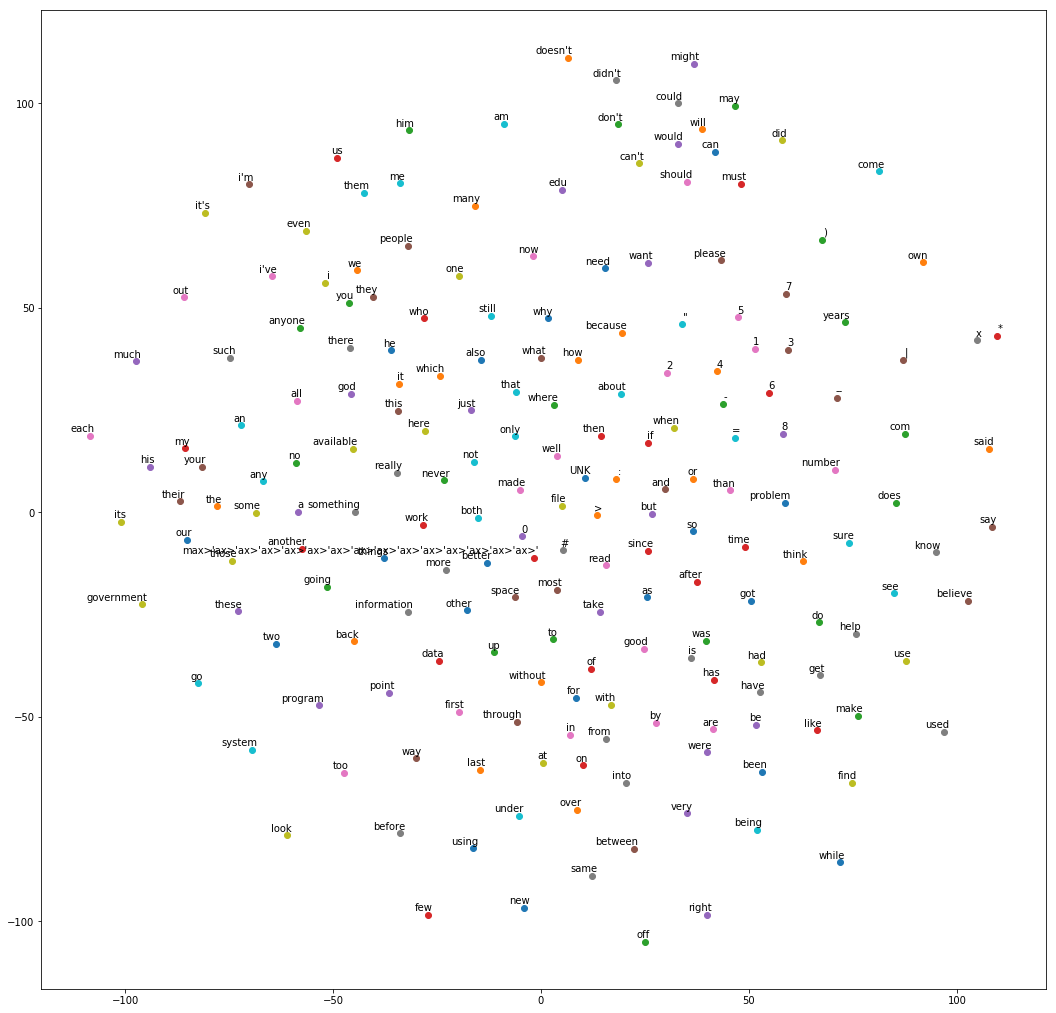

In [25]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 200
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
def get_most_similar(word, n=20):
    idx = dictionary[word]
#     sim = cosine_similarity(X=)
    sim = cosine_similarity(X=final_embeddings[idx].reshape(1, -1), Y=final_embeddings)
    idxs = np.argsort(sim)[0][::-1][1:n]
    for sim_idx in idxs:
        print(reverse_dictionary[sim_idx])
get_most_similar("can't")

would
will
don't
c/a)
max>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'
can
/lib/libx11
not
main_win
cannot
tithe
067
p/n:
live,
to
that
UNK
if
_only_


In [1]:
from gensim.models import KeyedVectors

In [4]:
%%time
model = KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin', binary=True)

CPU times: user 47.1 s, sys: 3.51 s, total: 50.6 s
Wall time: 50.6 s


In [5]:
model.similar_by_word('i', topn=20)

[('ive', 0.6900695562362671),
 ('im', 0.6873290538787842),
 ('i_cant', 0.6835387945175171),
 ('i_couldnt', 0.6701177358627319),
 ('i_dont', 0.6598323583602905),
 ('lol', 0.6584233045578003),
 ('i_hav', 0.6569403409957886),
 ('tho', 0.6455458402633667),
 ('i_realy', 0.6390955448150635),
 ('i_wouldnt', 0.6386457681655884),
 ('cuz_i', 0.6384180784225464),
 ('LOVE_YOU_ALL', 0.6341748237609863),
 ('coz_i', 0.633103609085083),
 ('sumthing', 0.6308635473251343),
 ('any1', 0.626294732093811),
 ('u', 0.6254582405090332),
 ('i_havent', 0.6249727010726929),
 ('thats', 0.6245152354240417),
 ('wud_u', 0.6224904656410217),
 ('haha', 0.6207189559936523)]